![splash pic i made](https://i.imgur.com/vKiH8As.png)


### Relevance
Principal Component Analysis (PCA) is a data-reduction technique that finds application in a wide variety of fields, including biology, sociology, physics, medicine, and audio processing.  PCA may be used as a "front end" processing step that feeds into additional layers of machine learning, or it may be used by itself, for example when doing data visualization.  It is so useful and ubiquitious that is is worth learning not only what it is for and what it is, but how to actually *do* it.

In this interactive worksheet, we work through how to perform PCA on a few different datasets, writing our own code as we go. 

### Other (better?) treatments
My treatment here was written several months after viewing... 
- the [excellent demo page at setosa.io](http://setosa.io/ev/principal-component-analysis/)
- this quick [1m30s video of a teapot](https://www.youtube.com/watch?v=BfTMmoDFXyE), 
- this [great StatsQuest video](https://www.youtube.com/watch?v=FgakZw6K1QQ)
- this [lecture from Andrew Ng's course](https://www.youtube.com/watch?v=rng04VJxUt4)


## Basic Idea
Put simply, PCA involves making a coordinate transformation (i.e., a rotation) from the arbitrary axes (or "features") you started with to a set of axes 'aligned with the data itself,' and doing this almost always means that you can get rid of a few of these 'components' of data that have small variance without suffering much in the way of accurcy while saving yourself a *ton* of computation. 

 <small>Once you "get it," you'll find PCA to be almost no big deal, if it weren't for the fact that it's so darn useful!</small> 

We'll define the following terms as we go, but here's the process in a nutshell:
1. Covariance: Find the *covariance matrix* for your dataset
2. Eigenvectors: Find the *eigenvectors* of that matrix (these are the "components" btw)
3. Ordering: Sort the eigenvectors/'dimensions' from biggest to smallest variance
4. Projection / Data reduction: Use the eigenvectors corresponding to the largest variance to project the dataset into a reduced- dimensional space
6. (Check: How much did we lose by that truncation?)

# Caveats
Since PCA will involve making linear transformations, 
there are some situations where PCA won't help but...pretty much it's handy enough that it's worth giving it a shot!


# Covariance
If you've got two data dimensions and they vary together, then they are co-variant. 

**Example:** Two-dimensional data that's somewhat co-linear:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='notebook'
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)



N = 100 
x = np.random.normal(size=N)
y = 0.5*x + 0.2*(np.random.normal(size=N))

fig = go.Figure(data=[go.Scatter(x=x, y=y, mode='markers', 
                marker=dict(size=8,opacity=0.5), name="data" )])
fig.update_layout( xaxis_title="x", yaxis_title="y",
    yaxis = dict(scaleanchor = "x",scaleratio = 1) )
fig.show()

### Variance
So, for just the $x$ component of the above data, there's some *mean* value (which in this case is zero), and there's some *variance* about this mean: technically **the variance is the average of the squared differences from the mean.** If you're familiar with the standard deviation, usually denoted by $\sigma$, the variance is just the square of the standard deviation.  If $x$ had units of meters, the variance $\sigma^2$ would have units of meters^2. 

Think of the variance as the "spread," or "extent" of the data, about some particular axis (or input, or "feature").

Similarly we can look at the variance in just the $y$ component of the data.  For the above data, the variances in $x$ and $y$ are

In [ ]:
print("Variance in x =",np.var(x))
print("Variance in y =",np.var(y))

Variance in x = 1.3787878226116232
Variance in y = 0.39082752915445373



### Covariance 
You'll notice in the above graph that as $x$ varies, so does $y$ -- pretty much.  So $y$ is "*covariant*" with $x$.  ["Covariance indicates the level to which two variables vary together."](https://docs.scipy.org/doc/numpy/reference/generated/numpy.cov.html)  To compute it, it's kind of like the regular variance, except that instead of squaring the deviation from the mean for one variable, we multiply the deviations for the two variables:

$${\rm Cov}(x,y) = {1\over N-1}\sum_{j=1}^N (x_j-\mu_x)(y_j-\mu_j),$$
where $\mu_x$ and $\mu_y$ are the means for the x- and y- componenets of the data, respectively.  Note that you can reverse $x$ and $y$ and get the same result, and the covariance of a variable with itself is just the regular variance -- but with one caveat! 

The caveat is that we're dividing by $N-1$ instead of $N$, so unlike the regular variance we're not quite taking the mean.  Why this?  Well, for large datasets this makes essentially no difference, but for small numbers of data points, using $N$ can give values that tend to be a bit too small for most people's tastes, so the $N-1$ was introduced to "reduce small sample bias." 

In Python code, the covariance calculation looks like

In [ ]:
def covariance(a,b):
    return ( (a - a.mean())*(b - b.mean()) ).sum() / (len(a)-1)

print("Covariance of x & y =",covariance(x,y))
print("Covariance of y & x =",covariance(x,y))
print("Covariance of x with itself =",covariance(x,x),", variance of x =",np.var(x))
print("Covariance of y with itself =",covariance(y,y),", variance of x =",np.var(y))

Covariance of x & y = 0.6883243158931873
Covariance of y & x = 0.6883243158931873
Covariance of x with itself = 1.3927149723349728 , variance of x = 1.3787878226116232
Covariance of y with itself = 0.3947752819741957 , variance of x = 0.39082752915445373


## Covariance matrix
So what we do is we take the covariance of every variable with every variable (including itself) and make a matrix out of it.  Along the diagonal will be the variance of each variable (except for that $N-1$ in the denominator), and the rest of the matrix will be the covariances.  Note that since the order of the variables doesn't matter when computing covariance, the matrix will be *symmetric* (i.e. it will equal its own transpose, i.e. will have a reflection symmetry across the diagonal) and thus will be a *square* matrix. 

Numpy gives us a handy thing to call:

In [ ]:
data = np.stack((x,y),axis=1)   # pack the x & y data together in one 2D array
print("data.shape =",data.shape)
cov = np.cov(data.T)   # .T b/c numpy wants varibles along rows rather than down columns?
print("covariance matrix =\n",cov)

data.shape = (100, 2)
covariance matrix =
 [[1.39271497 0.68832432]
 [0.68832432 0.39477528]]


# Some 3D data to work with
Now that we know what a covariance matrix is, let's generate some 3D data that we can use for what's coming next.  Since there are 3 variables or 3 dimensions, the covariance matrix will now be 3x3.

In [ ]:
z = -.5*x + 2*np.random.uniform(size=N)
data = np.stack((x,y,z)).T
print("data.shape =",data.shape)
cov = np.cov(data.T)
print("covariance matrix =\n",cov)

# Plot our data
import plotly.graph_objects as go
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,mode='markers', marker=dict(size=8,opacity=0.5), name="data" )])
fig.update_layout( xaxis_title="x", yaxis_title="y", yaxis = dict(scaleanchor = "x",scaleratio = 1) )
fig.show()

data.shape = (100, 3)
covariance matrix =
 [[ 1.39271497  0.68832432 -0.75976119]
 [ 0.68832432  0.39477528 -0.39059862]
 [-0.75976119 -0.39059862  0.74872195]]


(Note that even though our $z$ data didn't explicitly depend on $y$, the fact that $y$ is covariant with $x$ means that $y$ and $z$ 'coincidentally' have a nonzero covariance.  This sort of thing shows up in many datasets where two variables are correlated and may give rise to 'confounding' factors.)  

So now we have a covariance matrix.  The next thing in PCA is find the 'principal components'.  This means the directions along which the data varies the most.  You can kind of estimate these by rotating the 3D graph above.  See also [this great YouTube video of a teapot](https://www.youtube.com/watch?v=BfTMmoDFXyE) (1min 30s) that explains PCA in this manner. 


To do Principal Component Analysis, we need to find the aforementioned "components," and this requires finding *eigenvectors* for our dataset's covariance matrix.

# What is an eigenvector, *really*?
First a **definition**.  (Stay with me!  We'll flesh this out in what comes after this.)

Given some matrix (or 'linear operator') ${\bf A}$ with dimensions $n\times n$ (i.e., $n$ rows and $n$ columns), there exist a set of $n$ vectors $\vec{v}_i$ (each with dimension $n$, and $i = 1...n$ counts which vector we're talking about) **such that** multiplying one of these vectors by ${\bf A}$ results in a vector (anti)parallel to $\vec{v}_i$, with a length that's multiplied by some constant $\lambda_i$.  In equation form:

$${\bf A}\vec{v}_i = \lambda_i \vec{v}_i,\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ (1)$$


where the constants $\lambda_i$ are called *eigenvalues* and the vectors $\vec{v}_i$ are called *eigenvectors*. 

<span style="text-align:right; font-style:italic; font-size:70%;">(Note that I'm departing a bit from common notation that uses $\vec{x}_i$ instead of $\vec{v}_i$; I don't want people to get confused when I want to use $x$'s for coordinate variables.)</span>

A graphical version of this is shown in Figure 1: 

![picture of eigenvectors](https://i.imgur.com/rUcGpVn.png)


> Figure 1. "An eigenvector is a vector that a linear operator sends to a multiple of itself" -- [Daniel McLaury](https://www.quora.com/What-does-Eigen-mean/answer/Daniel-McLaury) 


### Brief Q & A before we go on:

1. "So what's with the 'eigen' part?"  That's a German prefix, which in this context means "inherent" or "own". 
2. "Can a non-square matrix have eigenvectors?"  Well,...no, and think of it this way: If $\bf{A}$ were an $n\times m$ matrix (where $m <> n$), then it would be mapping from $n$ dimensions into $m$ dimensions, but on the "other side" of the equation with the $\lambda_i \vec{v}_i$, *that* would still have $n$ dimensions, so... you'd be saying an $n$-dimensional object equals an $m$-dimensional object, which is a no-go. 
3. "But my dataset has many more rows than columns, so what am I supposed to do about that?"  Just wait! It'll be ok.  We're not actually going to take the eigenvectors of the dataset 'directly', we're going to take the eigenvectors of the *covariance matrix* of the dataset.
4. "Are eigenvectors important?"
You bet! They get used in many areas of science. I first encountered them in quantum mechanics.*
They describe the "principal vectors" of many objects, or "normal modes" of oscillating systems.  They get used in [computer vision](https://www.visiondummy.com/2014/03/eigenvalues-eigenvectors/), and... lots of places.   You'll see them almost anywhere matrices & tensors are employed, such as our topic for today: Data science!

*<small>Ok that's not quite true: I first encountered them in an extremely boring Linear Algebra class taught by an extremely boring NASA engineer who thought he wanted to try teaching.  But it wasn't until later that I learned anything about their relevance for...anything.  Consquently I didn't "learn them" very well so writing this is a helpful review for me.</small>

# How to find the eigenvectors of a matrix

You call a library routine that does it for you, of course! ;-)

In [ ]:
from numpy import linalg as LA
lambdas, vs = LA.eig(cov)
lambdas, vs

(array([2.23494234, 0.25770373, 0.04356613]),
 array([[-0.77200047, -0.44874891, -0.45015518],
        [-0.39455037, -0.21693649,  0.89289896],
        [ 0.49834253, -0.86692731,  0.00957898]]))

Ok sort of kidding; we'll do it "from scratch".  But, one caveat before we start: Some matrices can be "weird" or "problematic" and have things like "singular values."  There are  sophisticated numerical libraries for doing this, and joking aside, for real-world numerical applications you're better off calling a library routine that other very smart and very careful people have written for you.  But for now, we'll do the straightforward way which works pretty well for many cases.
We'll follow the basic two steps:


1.   Find the eigenvalues  
2.   'Plug in' each eigenvalue to get a system of linear equations for the values of the components of the corresponding eigenvector
3. Solve this linear system. 



## 1. Find the eigenvalues  
Ok I'm hoping you at least can recall what a [determinant](https://en.wikipedia.org/wiki/Determinant) of a matrix is. Many people, even if they don't know what a determinant is good for (e.g. tons of proofs & properties all rest on the determinant), they still at least remember how to calculate one. 

The way to get the eigenvalues is to take the determinant of the difference between a $\bf{A}$ and $\lambda$ times the *identity matrix* $\bf{I}$ (which is just ones along the diagonal and zeros otherwise) and set that difference equal to zero...

$$det( \bf{A} - \lambda I) = 0 $$

> <small>Just another observation: Since ${\bf I}$ is a square matrix, that means $\bf{A}$ has to be a square matrix too.</small>

Then solving for $\lambda$ will give you a *polynomial equation* in $\lambda$, the solutions to (or roots of) which are the eigenvectors $\lambda_i$. 

Let's do an example:

$$
{\bf A} = 
\begin{bmatrix}
-2 & 2 & 1\\
-5 & 5 & 1\\
-4 & 2 & 3
\end{bmatrix}
$$
To find the eigenvalues we set 
$$
det( \bf{A} - \lambda I) =
\begin{vmatrix}
-2-\lambda & 2 & 1\\
-5 & 5-\lambda & 1\\
-4 & 2 & 3-\lambda
\end{vmatrix} = 0.$$


This gives us the equation...
$$0 = \lambda^3 - 6\lambda^2 + \lambda - 6$$

which has the 3 solutions (in descending order)
$$ \lambda = 3, 2, 1.$$ 

<small>*(Aside: to create an integer matrix with integer eigenvalues, I used [this handy web tool](https://ericthewry.github.io/integer_matrices/))*.</small>

Just to check that against the numpy library:



In [ ]:
A = np.array([[-2,2,1],[-5,5,1],[-4,2,3]])

def sorted_eig(A):  # For now we sort 'by convention'. For PCA the sorting is key. 
    lambdas, vs = LA.eig(A)
    # Next line just sorts values & vectors together in order of decreasing eigenvalues
    lambdas, vs = zip(*sorted(zip(list(lambdas), list(vs.T)),key=lambda x: x[0], reverse=True))
    return lambdas, np.array(vs).T  # un-doing the list-casting from the previous line

lambdas, vs = sorted_eig(A)
lambdas # hold off on printing out the eigenvectors until we do the next part!

(3.0000000000000013, 1.999999999999999, 1.0000000000000004)

Close enough!  


# 2. Use the eigenvalues to get the eigenvectors

Although it was anncounced in mid 2019 that [you can get eigenvectors directly from eigenvalues](https://arxiv.org/abs/1908.03795), the usual way people have done this for a very long time is to go back to the matrix $\bf{A}$ and solve the *linear system* of equation (1) above, for each of the eigenvalues.  For example, for $\lambda_1=-1$, we have 

$$
{\bf}A \vec{v}_1 = -\vec{v}_1
$$
i.e.

$$
\begin{bmatrix}
-2 & 2 & 1\\
-5 & 5 & 1\\
-4 & 2 & 3
\end{bmatrix}
\begin{bmatrix}
v_{1x}\\
v_{1y}\\
v_{1z}\\
\end{bmatrix}
= 
-\begin{bmatrix}
v_{1x}\\
v_{1y}\\
v_{1z}\\
\end{bmatrix}
$$
This amounts to 3 equations for 3 unknowns,...which I'm going to assume you can handle...  For the other eigenvalues things proceed similarly.  The solutions we get for the 3 eigenvalues are: 

$$\lambda_1 = 3: \ \ \ \vec{v}_1 = (1,2,1)^T$$
  

$$\lambda_2 = 2: \ \ \ \vec{v}_2 = (1,1,2)^T$$

$$\lambda_3 = 1: \ \ \ \vec{v}_3 = (1,1,1)^T$$


Since our original equation (1) allows us to scale eigenvectors by any artibrary constant, often we'll express eigenvectors as *unit* vectors $\hat{v}_i$.  This will amount to dividing by the length of each vector, i.e. in our example multiplying by $(1/\sqrt{6},1/\sqrt{6},1/\sqrt{3})$.  

In this setting 

$$\lambda_1 = 3: \ \ \ \hat{v}_1 = (1/\sqrt{6},2/\sqrt{6},1/\sqrt{6})^T$$
  
$$\lambda_2 = 2: \ \ \ \hat{v}_2 = (1/\sqrt{6},1/\sqrt{6},2/\sqrt{6})^T$$

$$\lambda_3 = 1: \ \ \ \hat{v}_3 = (1,1,1)^T/\sqrt{3}$$



Checking our answers (left) with numpy's answers (right):

In [ ]:
print(" "*15,"Ours"," "*28,"Numpy")
print(np.array([1,2,1])/np.sqrt(6), vs[:,0])
print(np.array([1,1,2])/np.sqrt(6), vs[:,1])
print(np.array([1,1,1])/np.sqrt(3), vs[:,2])

                Ours                              Numpy
[0.40824829 0.81649658 0.40824829] [-0.40824829 -0.81649658 -0.40824829]
[0.40824829 0.40824829 0.81649658] [0.40824829 0.40824829 0.81649658]
[0.57735027 0.57735027 0.57735027] [0.57735027 0.57735027 0.57735027]


The fact that the first one differs by a multiplicative factor of -1 is not an issue. Remember: eigenvectors can be multiplied by an arbitrary constant.  (Kind of odd that numpy doesn't choose the positive version though!) 

One more check: let's multiply our eigenvectors times A to see what we get:

In [ ]:
print("A*v_1 / 3 = ",np.matmul(A, np.array([1,2,1]).T)/3 ) # Dividing by eigenvalue 
print("A*v_2 / 2 = ",np.matmul(A, np.array([1,1,2]).T)/2 ) #    to get vector back
print("A*v_3 / 1 = ",np.matmul(A, np.array([1,1,1]).T) )

A*v_1 / 3 =  [1. 2. 1.]
A*v_2 / 2 =  [1. 1. 2.]
A*v_3 / 1 =  [1 1 1]


Great! Let's move on.  Back to our data!

# Eigenvectors for our sample 3D dataset

Recall we named our 3x3 covariance matrix 'cov'.  So now we'll compute its eigenvectors, and then re-plot our 3D data and also plot the 3 eigenvectors with it...

In [ ]:
# Now that we know we can get the same answers as the numpy library, let's use it
lambdas, vs = sorted_eig(cov)  # Compute e'vals and e'vectors of cov matrix 
print("lambdas, vs =\n",lambdas,"\n",vs)

# Re-plot our data
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,mode='markers',  
        marker=dict(size=8,opacity=0.5), name="data" ) ])

# Draw some extra 'lines' showing eigenvector directions
n_ev_balls = 50    # the lines will be made of lots of balls in a line
ev_size= 3    # size of balls
t = np.linspace(0,1,num=n_ev_balls)  # parameterizer for drawing along vec directions

for i in range(3):   # do this for each eigenvector 
    # Uncomment the next line to scale (unit) vector by size of the eigenvalue
    # vs[:,i] *= lambdas[i] 
    ex, ey, ez = t*vs[0,i], t*vs[1,i],  t*vs[2,i]
    fig.add_trace(go.Scatter3d(x=ex, y=ey, z=ez,mode='markers',
                marker=dict(size=ev_size,opacity=0.8), name="v_"+str(i+1)))

fig.update_layout( xaxis_title="x", yaxis_title="y", yaxis = dict(scaleanchor = "x",scaleratio = 1) )
fig.show()

lambdas, vs =
 (2.2349423420072574, 0.2577037297303398, 0.043566129727355414) 
 [[-0.77200047 -0.44874891 -0.45015518]
 [-0.39455037 -0.21693649  0.89289896]
 [ 0.49834253 -0.86692731  0.00957898]]


Things to note from the above graph:

1. The first (red) eigenvector points along the direction of biggest variance 
2. The second (greenish) eigenvector points along the direction of second-biggest variance
3. The third (purple) eigenvector points along the  direction of smallest variance.  

(If you edit the above code to rescale the vector length by the eigenvector, you'll really see these three point become apparent!)

## "Principal Component" Analysis
Now we have our components (=eigenvectors), and we have them "ranked" by their "significance."  Next we will *eliminate* one or more of the less-significant directions of variance.  In other words, we will *project* the data onto the various *principal components* by projecting *along* the less-significant components.  Or even simpler: We will "squish" the data along the smallest-variance directions.  

For the above 3D dataset, we're going to squish it into a 2D pancake -- by projecting along the direction of the 3rd (purple) eigenvector onto the plane defined by the 1st (red) and 2nd (greenish) eigenvectors.

Yea, but how to do this projection?  

## Projecting the data
It's actually not that big of a deal.  All we have to do is multiply by the eigenvector (matrix)!   

**OH WAIT!  Hey, you want to see a cool trick!?** Check this out:




In [ ]:
lambdas, vs = sorted_eig(cov)  

proj_cov = vs.T @ cov @ vs   # project the covariance matrix, using eigenvectors
proj_cov

array([[2.23494234e+00, 1.70482998e-16, 2.02405702e-16],
       [5.45916585e-17, 2.57703730e-01, 1.33554659e-16],
       [2.12481941e-16, 1.73636845e-16, 4.35661297e-02]])

What was THAT?  Let me clean that up a bit for you...

In [ ]:
proj_cov[np.abs(proj_cov) < 1e-15] = 0
proj_cov

array([[2.23494234, 0.        , 0.        ],
       [0.        , 0.25770373, 0.        ],
       [0.        , 0.        , 0.04356613]])

**Important point:** What you just saw is the whole reason eigenvectors get used for so many things, because they give you a 'coordinate system' where different 'directions' *decouple* from each other.  See, the system has its own (German: eigen) inherent set of orientations which are different the 'arbitrary' coordinates that we 'humans' may have assigned initially.   

The numbers in that matrix are the covariances *in the directions* of the eigenvectors, instead of in the directions of the original x, y, and z.  

So really all we have to do is make a *coordinate transformation* using the matrix of eigenvectors, and then in order to project we'll literally just *drop* a whole index's-worth of data-dimension in this new coordinate system. :-) 

So, instead of $x$, $y$ and $z$, let's have three coordinates which (following physicist-notation) we'll call $q_1$, $q_2$ and $q_3$, and these will run along the directions given by the three eigenvectors. 

Let's write our data as a N-by-3 matrix, where N is the number of data points we have.




In [ ]:
data = np.stack((x,y,z),axis=1)
data.shape   # we had a 100 data points, so expecting 100x3 matrix 

(100, 3)

There are two ways of doing this, and I'll show you that they're numerically equivalent:

1. Use *all* the eigenvectors to "rotate" the full dataset into the new coordinate system. Then perform a projection by truncating the last column of the rotated data.
2. Truncate the last eigenvector, which will make a 3x2 projection matrix which will project the data onto the 2D plane defined by those two eigenvectors. 

Let's show them both:


In [ ]:
print("\n 1. All data, rotated into new coordinate system")
W = vs[:,0:3]  # keep the all the eigenvectors
new_data_all = data @ W  # project all the data 
print("Checking: new_data_all.shape =",new_data_all.shape)
print("New covariance matrix = \n",np.cov(new_data_all.T) )


print("\n 2. Truncated data projected onto principal axes of coordinate system")

W = vs[:,0:2]  # keep only the first and 2nd eigenvectors 
print("W.shape = ",W.shape) 
new_data_proj = data @ W   # project 
print("Checking: new_data_proj.shape =",new_data_proj.shape)
print("New covariance matrix in projected space = \n",np.cov(new_data_proj.T) )

# Difference between them
diff = new_data_all[:,0:2] - new_data_proj
print("\n Absolute maximum difference between the two methods = ",np.max(np.abs(diff)))


 1. All data, rotated into new coordinate system
Checking: new_data_all.shape = (100, 3)
New covariance matrix = 
 [[2.23494234e+00 4.35665465e-17 3.01388743e-16]
 [4.35665465e-17 2.57703730e-01 9.62562340e-17]
 [3.01388743e-16 9.62562340e-17 4.35661297e-02]]

 2. Truncated data projected onto principal axes of coordinate system
W.shape =  (3, 2)
Checking: new_data_proj.shape = (100, 2)
New covariance matrix in projected space = 
 [[2.23494234e+00 4.35665465e-17]
 [4.35665465e-17 2.57703730e-01]]

 Absolute maximum difference between the two methods =  0.0


...Nada.  The 2nd method will be faster computationally though, because it doesn't calculate stuff you're going to throw away. 

One more comparison between the two methods.
Let's take a look at the "full" dataset (in blue) vs. the projected dataset (in red):

In [ ]:
fig = go.Figure(data=[(go.Scatter3d(x=new_data_all[:,0], y=new_data_all[:,1], z=new_data_all[:,2],
        mode='markers', marker=dict(size=4,opacity=0.5), name="full data" ))])
fig.add_trace(go.Scatter3d(x=new_data_proj[:,0], y=new_data_proj[:,1], z=new_data_proj[:,0]*0,
        mode='markers', marker=dict(size=4,opacity=0.5), name="projected" ) )
fig.update_layout(scene_aspectmode='data')
fig.show()

<small>(Darn it, [if only Plot.ly would support orthographic projections](https://community.plot.ly/t/orthographic-projection-for-3d-plots/3897) [[2](https://community.plot.ly/t/orthographic-projection-instead-of-perspective-for-3d-plots/10035)] it'd be a lot easier to visually compare the two datasets!)</small>

# Beyond 3D
So typically we use PCA to throw out many more dimensions than just one.  Often this is used for data visualization but it's also done for feature reduction, i.e. to send less data into your machine learning algorithm.  (PCA can even be used just as a "multidimensional linear regression" algorithm, but you wouldn't want to!)

## How do you know how many dimensions to throw out?
In other words, how many 'components' should you choose to keep when 
doing PCA?  There are a few ways to make this *judgement call* -- it will involve a trade-off between accuracy and computational speed.
You can make a graph of the amount of variance you get as a function of how many components you keep, and often there will be a an 'elbow' at some point on the graph indicating a good cut-off point to choose. Stay tuned as we do the next example; we'll make such a graph. 
For more on this topic, see [this post by Arthur Gonsales](https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe).  


## Example: Handwritten Digits 
The [scikit-learn library](https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html) uses this as an example and I like it. It goes as follows:
1. Take a dataset of tiny 8x8 pixel images of handwritten digits.
2. Run PCA to break it down from 8x8=64 dimensions to just two or 3 dimensions.
3. Show on a plot how the different digits cluster in different regions of the space.
4. (This part we'll save for the Appendix: Draw boundaries between the regions and use this as a classifier.)

To be clear: In what follows, *each pixel* of the image counts as a "feature," i.e. as a dimension.  Thus an entire image can be represented as a single point in a multidimensional space, in which distance from the origin along each dimension is given by the pixel intensity.  In this example, the input space is *not* a 2D space that is 8 units wide and 8 units long, rather it consists of 8x8= 64 dimensions. 


(1797, 64) (1797,) 

This is supposed to be a '0':


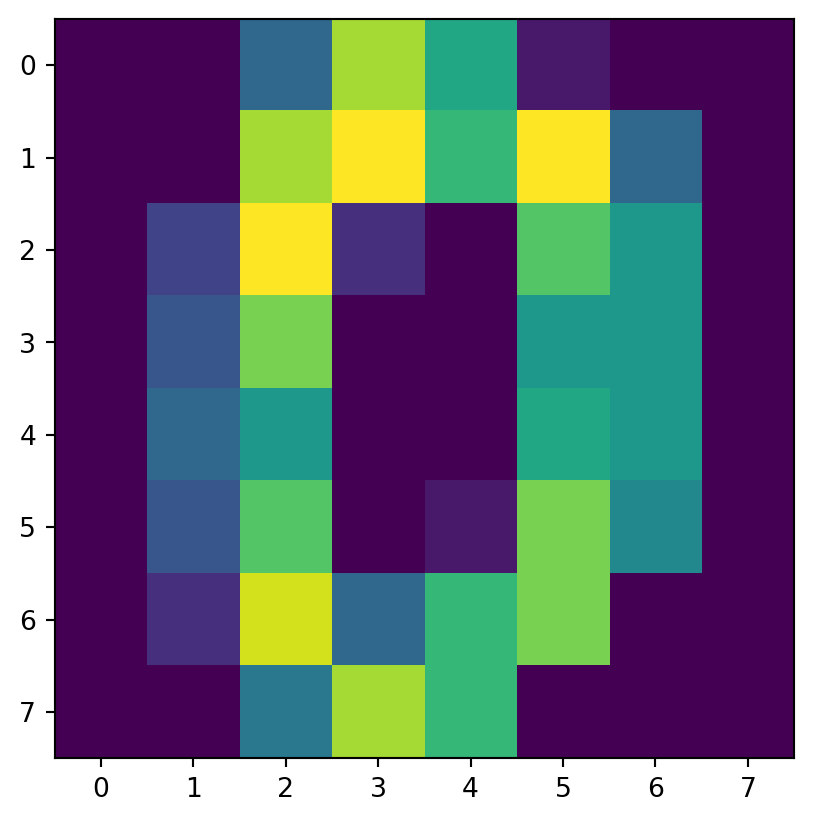

This is supposed to be a '1':


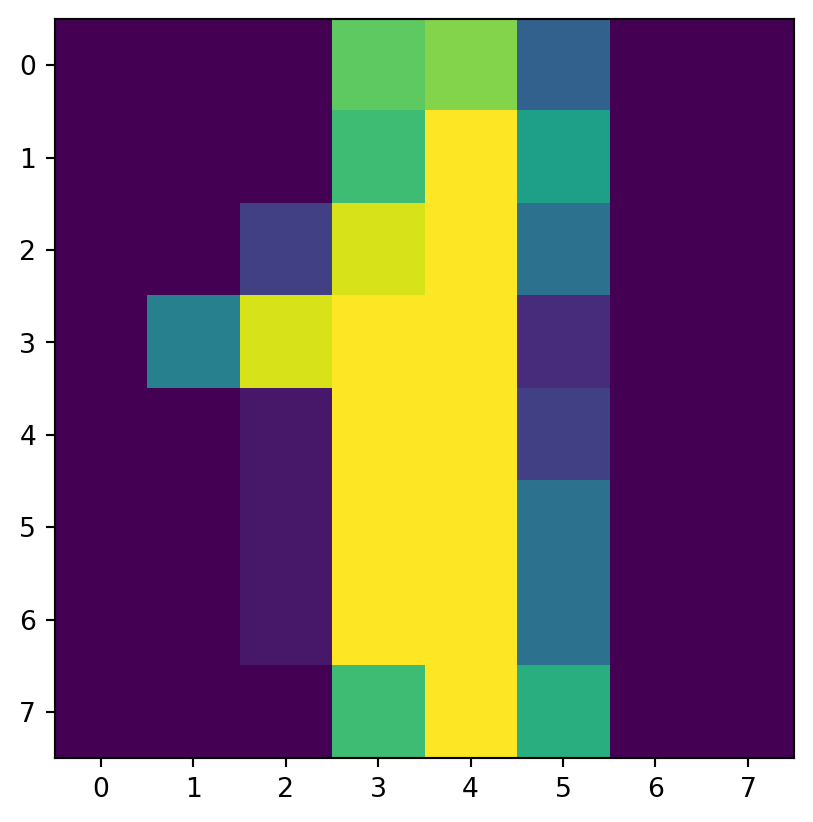

This is supposed to be a '2':


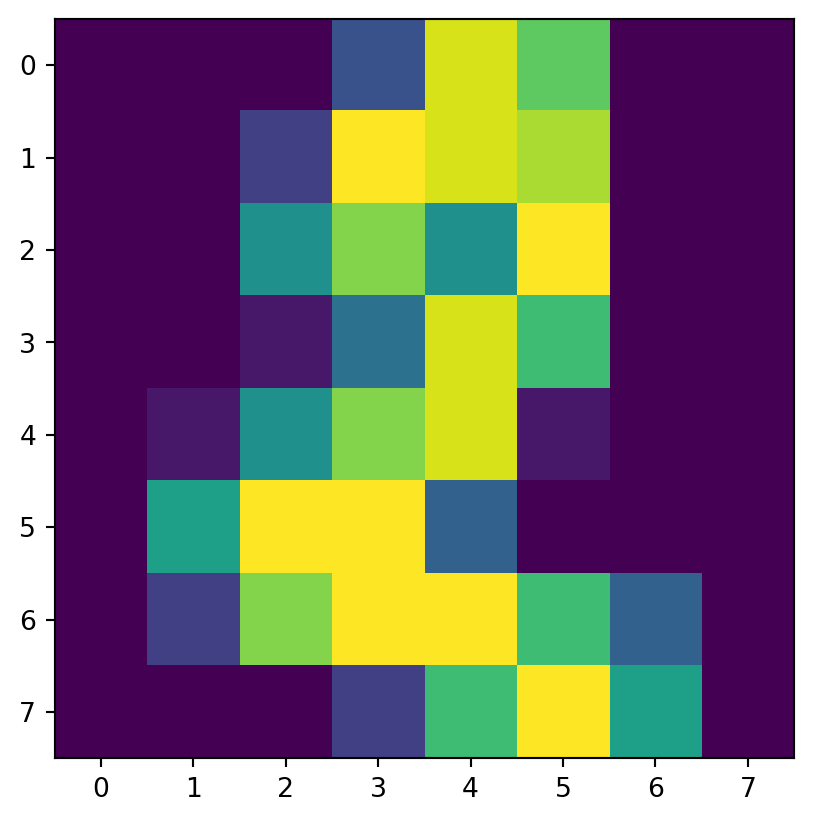

This is supposed to be a '3':


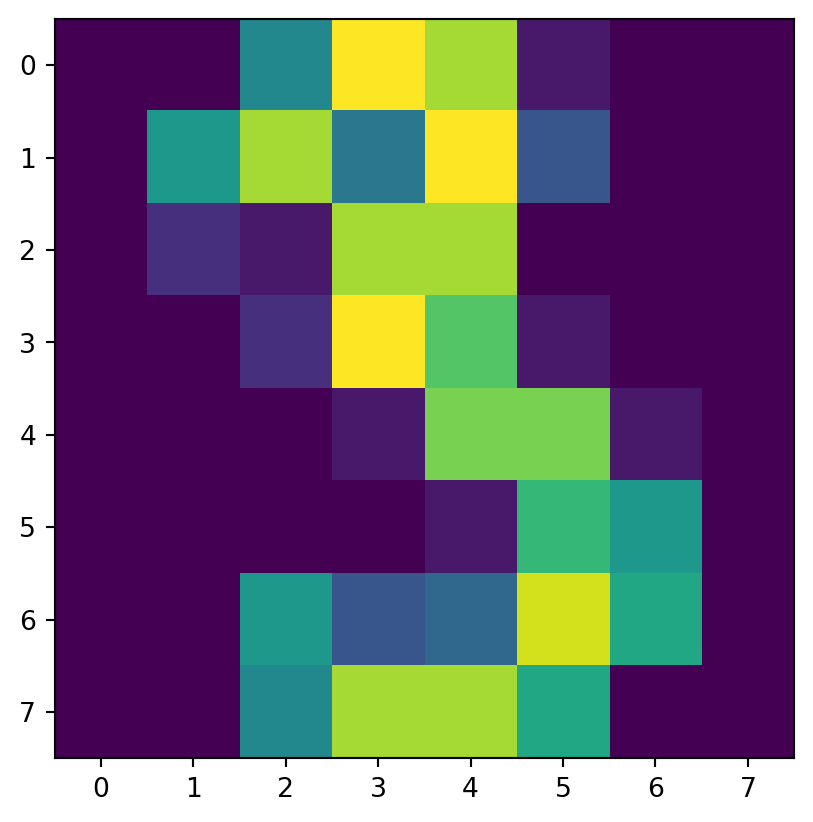

This is supposed to be a '4':


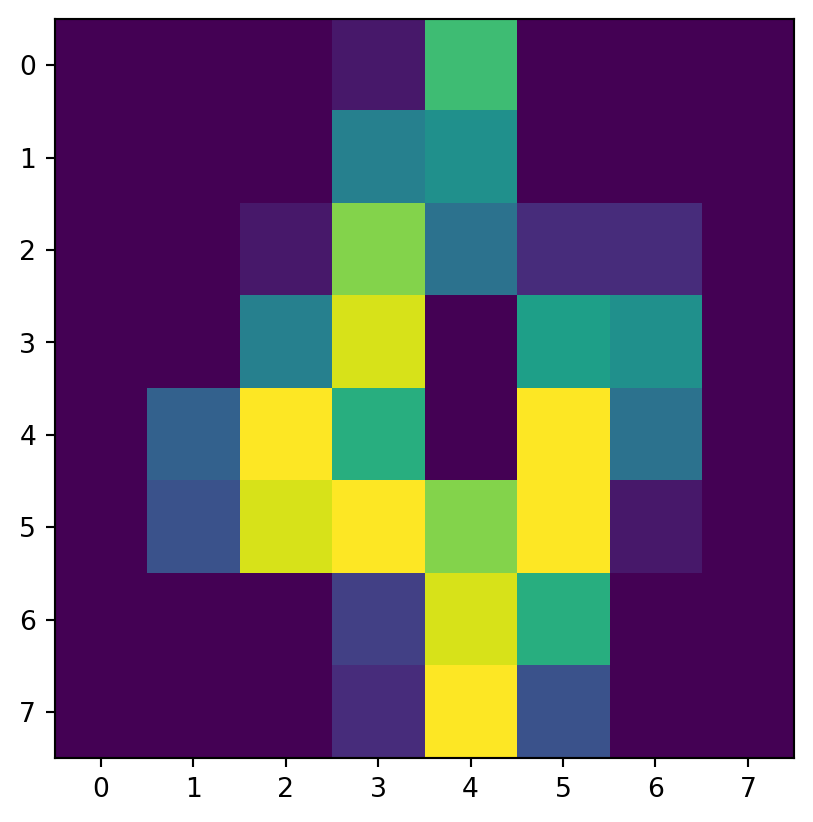

This is supposed to be a '5':


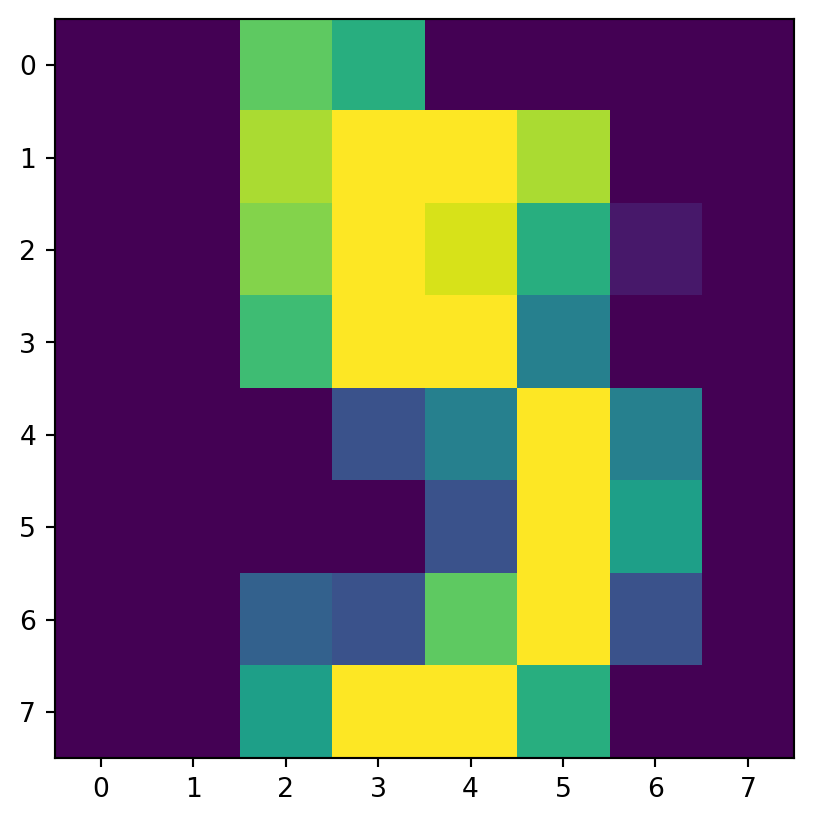

This is supposed to be a '6':


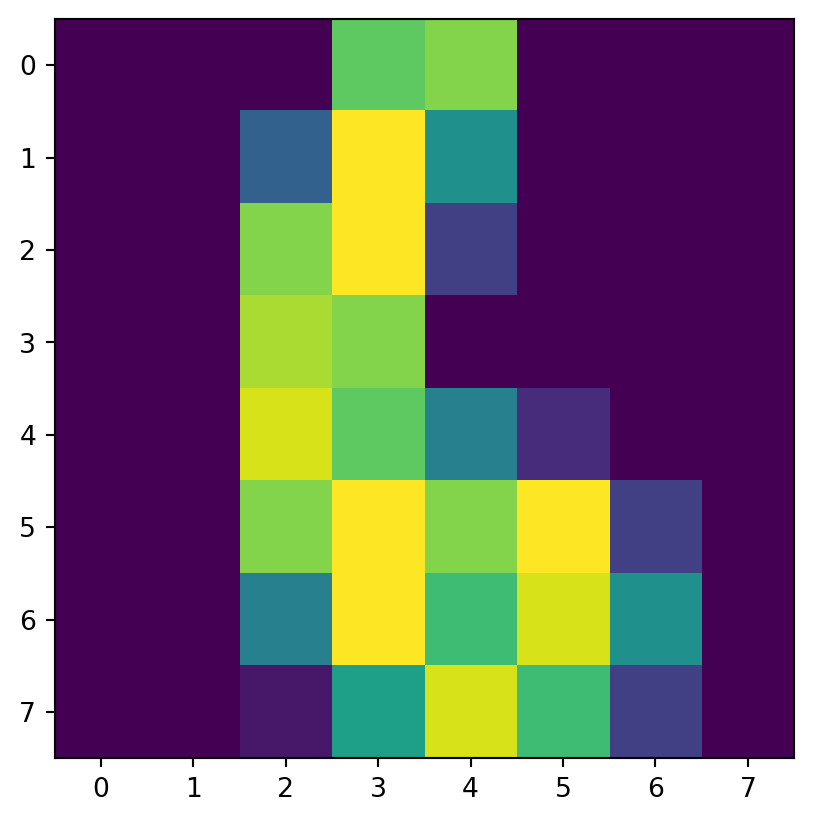

This is supposed to be a '7':


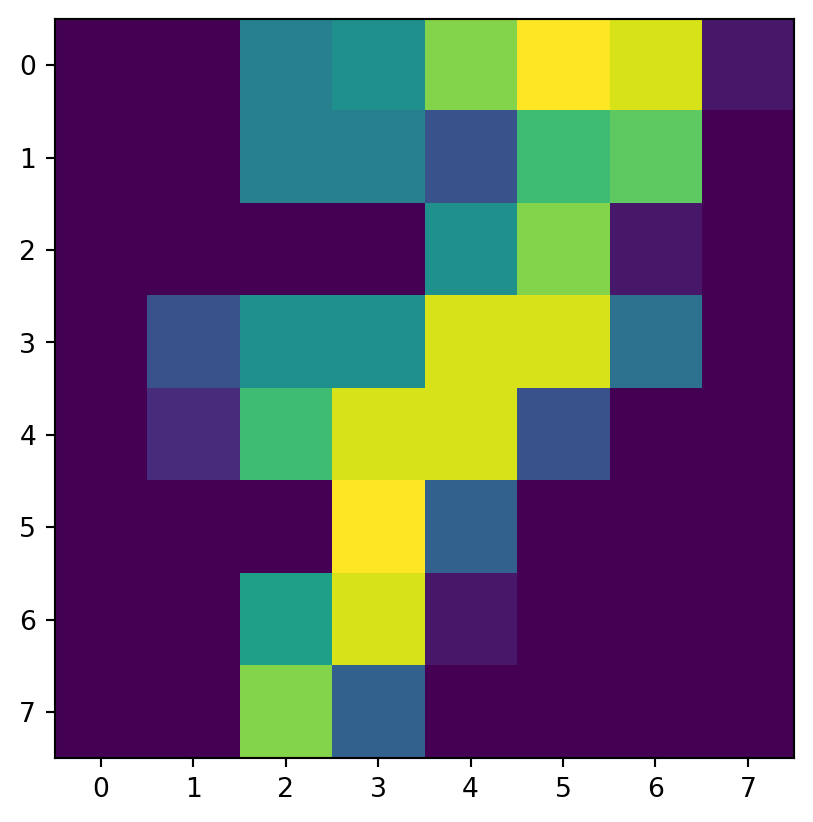

In [ ]:
from sklearn.datasets import load_digits 
from sklearn.decomposition import PCA
digits  = load_digits()
X = digits.data / 255.0 
Y = digits.target
print(X.shape, Y.shape,'\n')

# Let's look a a few examples
for i in range(8):  # show 8 examples 
    print("This is supposed to be a '",Y[i],"':",sep="")
    plt.imshow(X[i].reshape([8,8]))
    plt.show()

Now let's do the PCA thang... First we'll try going down to 2 dimensions.  This isn't going to work super great but we'll try: 

In [ ]:
digits_cov = np.cov(X.T)
print("digits_cov.shape = ",digits_cov.shape)
lambdas, vs = sorted_eig(np.array(digits_cov)) 

W = vs[:,0:2]  # just keep two dimensions
proj_digits = X @ W
print("proj_digits.shape = ", proj_digits.shape)

# Make the plot 
fig = go.Figure(data=[go.Scatter(x=proj_digits[:,0], y=proj_digits[:,1],# z=Y, #z=proj_digits[:,2],
                mode='markers', marker=dict(size=6, opacity=0.7, color=Y), text=['digit='+str(j) for j in Y] )])
fig.update_layout( xaxis_title="q_1", yaxis_title="q_2", yaxis = dict(scaleanchor = "x",scaleratio = 1) )
fig.update_layout(scene_camera=dict(up=dict(x=0, y=0, z=1), center=dict(x=0, y=0, z=0), eye=dict(x=0, y=0, z=1.5)))
fig.show()

digits_cov.shape =  (64, 64)
proj_digits.shape =  (1797, 2)


This is 'sort of ok': There are some regions that are mostly one kind of digit.  But you may say there's there's too much intermingling between classes for a lot of this plot.  So let's try it again with 3 dimensions for PCA:

In [ ]:
W = vs[:,0:3]  # just three dimensions
proj_digits = X @ W
print("proj_digits.shape = ", proj_digits.shape)

# Make the plot, separate them by "z" which is the digit of interest.  
fig = go.Figure(data=[go.Scatter3d(x=proj_digits[:,0], y=proj_digits[:,1], z=proj_digits[:,2],
                mode='markers', marker=dict(size=4, opacity=0.8, color=Y, showscale=True), 
                text=['digit='+str(j) for j in Y] )])
fig.update_layout(title="8x8 Handwritten Digits", xaxis_title="q_1", yaxis_title="q_2", yaxis = dict(scaleanchor = "x",scaleratio = 1) )
fig.show()

proj_digits.shape =  (1797, 3)


*Now* we can start to see some definition!  The 6's are pretty much in one area, the 2's are in another area, and the 0's are in still another, and so on.  There is some intermingling to be sure (particularly between the 5's and 8's), but you can see that this 'kind of' gets the job done, and instead of dealing with 64 dimensions, we're down to 3! 




## Graphing Variance vs. Components
Earlier we asked the question of how many components one should keep. To answer this quantitatively, we note that the eigenvalues of the covariance matrix are themselves measures of the variance in the datset.  So these eigenvalues encode the 'significance' that each feature-dimension has in the overall dataset.  We can plot these eigenvalues in order and then look for a 'kink' or 'elbow' in the graph as a place to truncate our representation... 

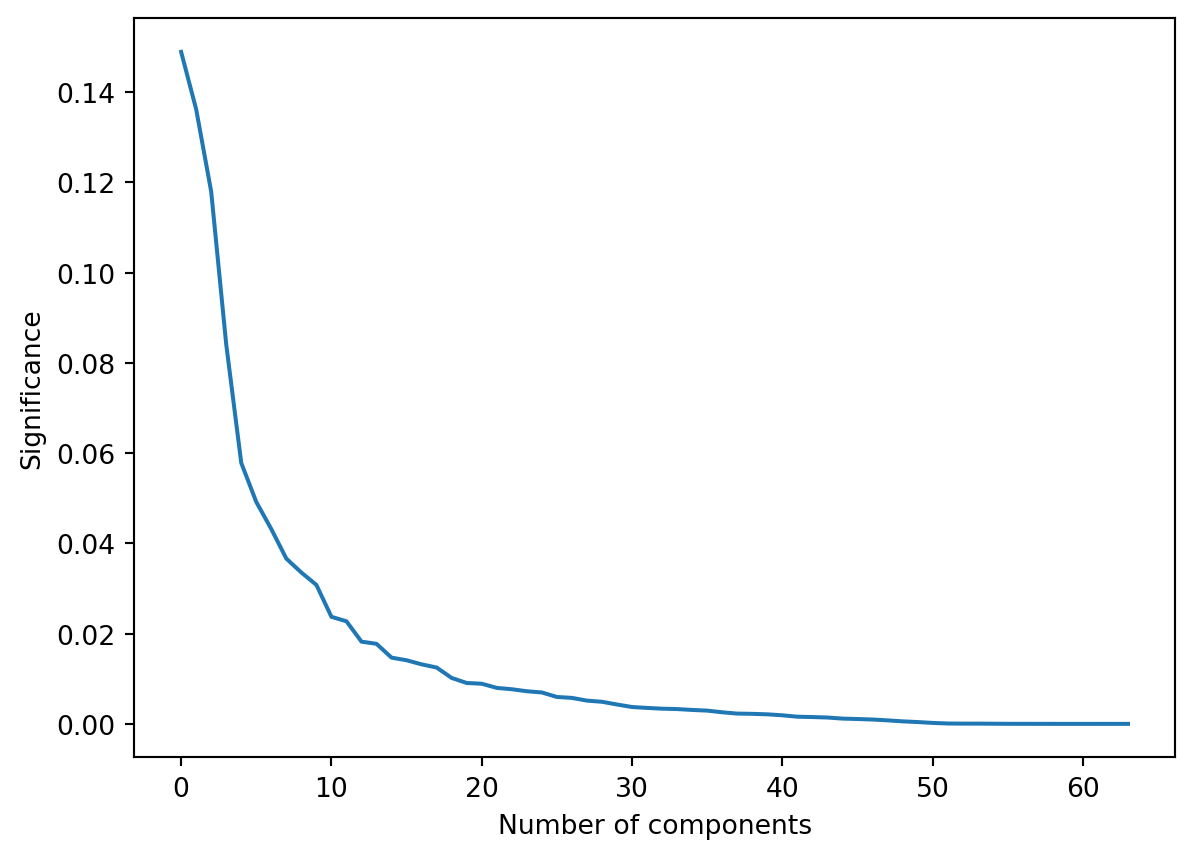

In [ ]:
plt.plot( np.abs(lambdas)/np.sum(lambdas) )
plt.xlabel('Number of components')
plt.ylabel('Significance') 
plt.show()

...So, if we were wanting to represent this data in more than 3 dimensions but less than the full 64, we might choose around 10 principal compnents, as this looks like roughly where the 'elbow' in the graph lies.  

# Interpretability
What is the meaning of the new coordinate axes or 'features' $q_1$, $q_2$, etc?  Sometimes there exists a compelling physical intepretation of these features (e.g., as in the case of eigenmodes of coupled oscillators), but often...there may not be any.  And yet we haven't even done any 'real machine learning' at this point! ;-) 

This is an important topic. Modern data regulations such as the European Union's [GDPR](https://en.wikipedia.org/wiki/General_Data_Protection_Regulation) require that models used in algorithmic decision-making be 'explainable'.  If the data being fed into such algorithmics is already abstracted via methods such as PCA, this could be an issue.  Thankfully, the linearity of the components mean that one can describe each principal component as a linear combination of inputs.  
 

## Further reading 

There are [many books](https://www.google.com/search?client=ubuntu&channel=fs&q=book+pca+principal+component+analysis&ie=utf-8&oe=utf-8) devoted entirely to the intricacies of PCA and its applications.   Hopefully this post has helped you get a better feel for how to construct a PCA transformation and what it might be good for.  To expand on this see the following...

### Examples & links
* ["Eigenstyle: Principal Component Analysis and Fashion"](https://graceavery.com/principalcomponentanalysisandfashion/) by Grace Avery.  Uses PCA on Fashion-MNIST. It's good!
* [Neat paper by my friend Dr. Ryan Bebej](https://link.springer.com/article/10.1007/s10914-008-9099-1) from when he was a student and used PCA to classify locomotion types of prehistoric acquatic mammals based on skeletal measurements alone. 
* [Andrew Ng's Machine Learning Course, Lecture on PCA](https://www.coursera.org/lecture/machine-learning/principal-component-analysis-algorithm-ZYIPa).  How I first learned about this stuff. 
* [PCA using Python](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60) by Michael Galarnyk.  Does similar things to what I've done here, although maybe better! 
* [Plot.ly PCA notebook examples](https://plot.ly/python/v3/ipython-notebooks/principal-component-analysis/)


# Appendix A: Overkill: Bigger Handwritten Digits
Sure, 8x8 digit images are boring. What about 28x28 images, as in the [MNIST dataset](http://yann.lecun.com/exdb/mnist/)?  Let's roll...


/Users/shawley/envs/blog/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning:

The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.



i = [14703]: This is supposed to be a 4:


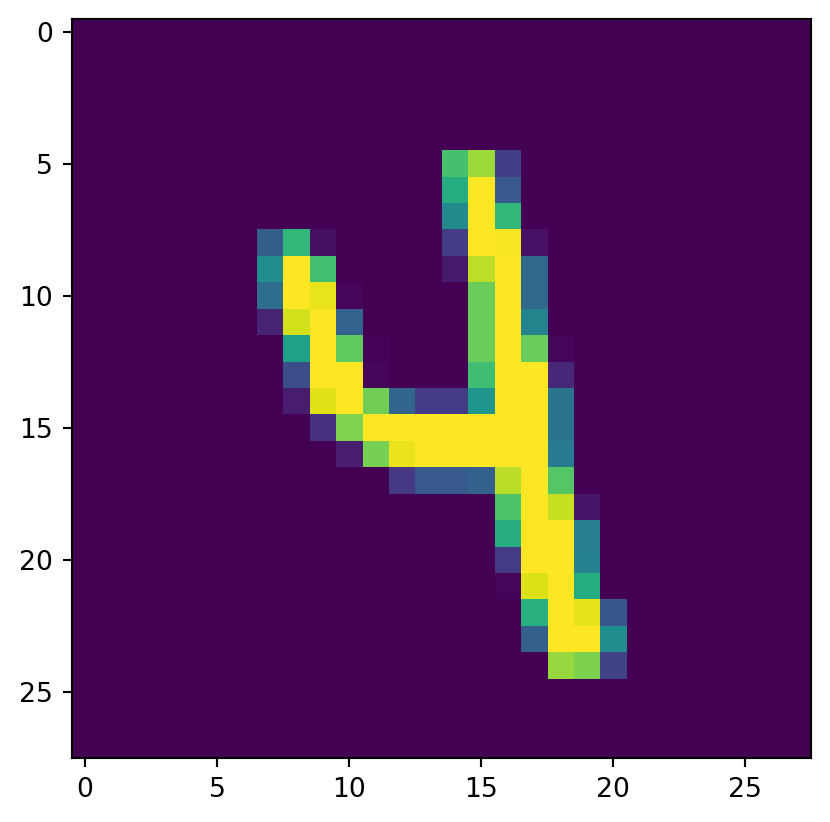

i = [26349]: This is supposed to be a 9:


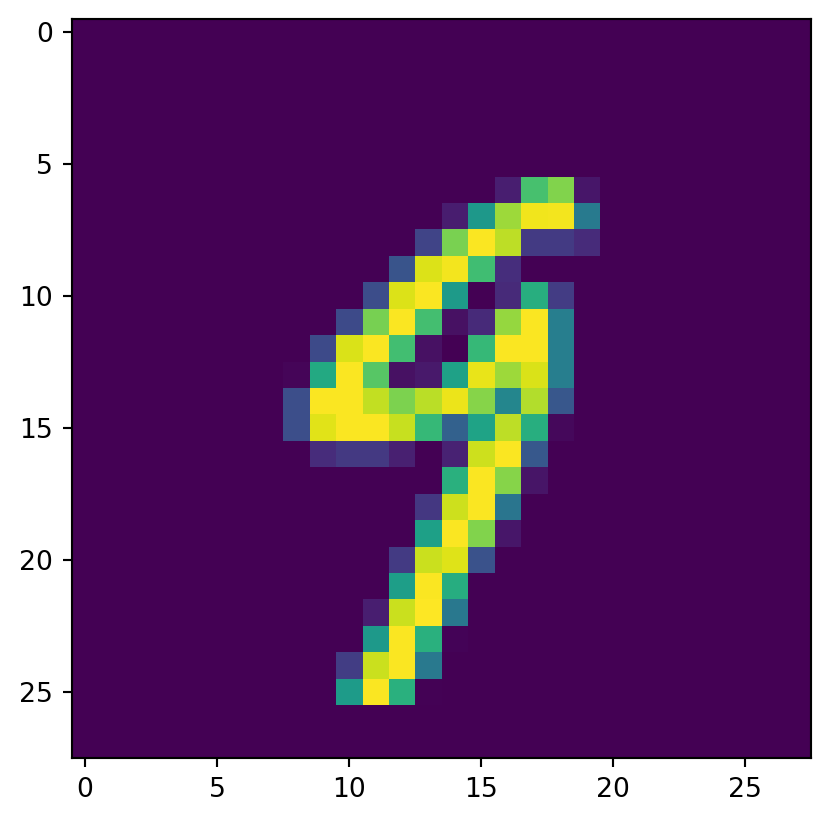

i = [48622]: This is supposed to be a 7:


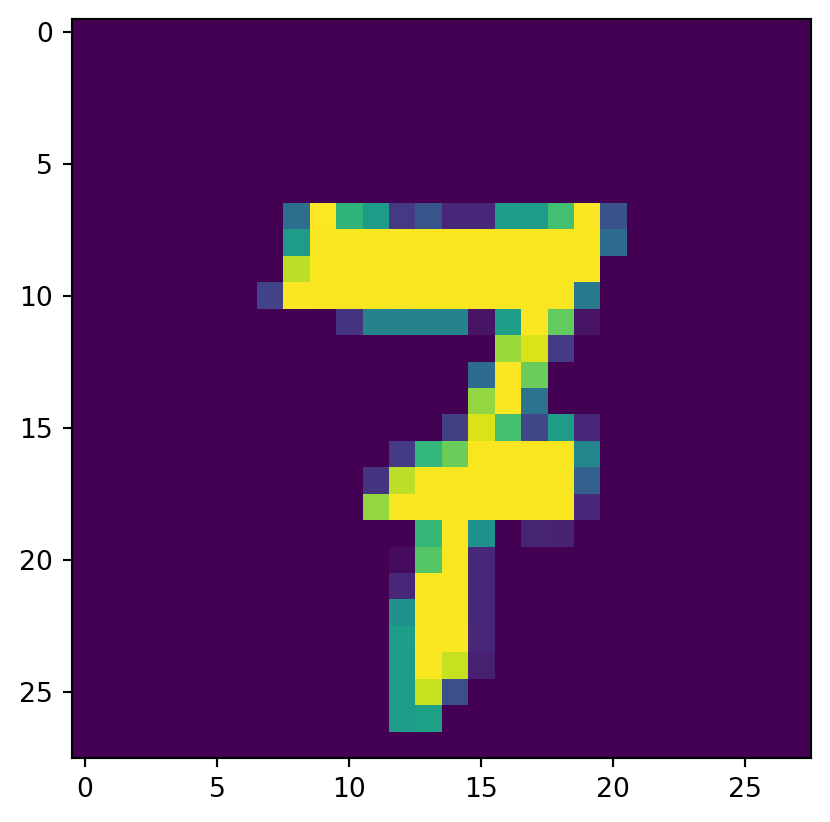

i = [20164]: This is supposed to be a 9:


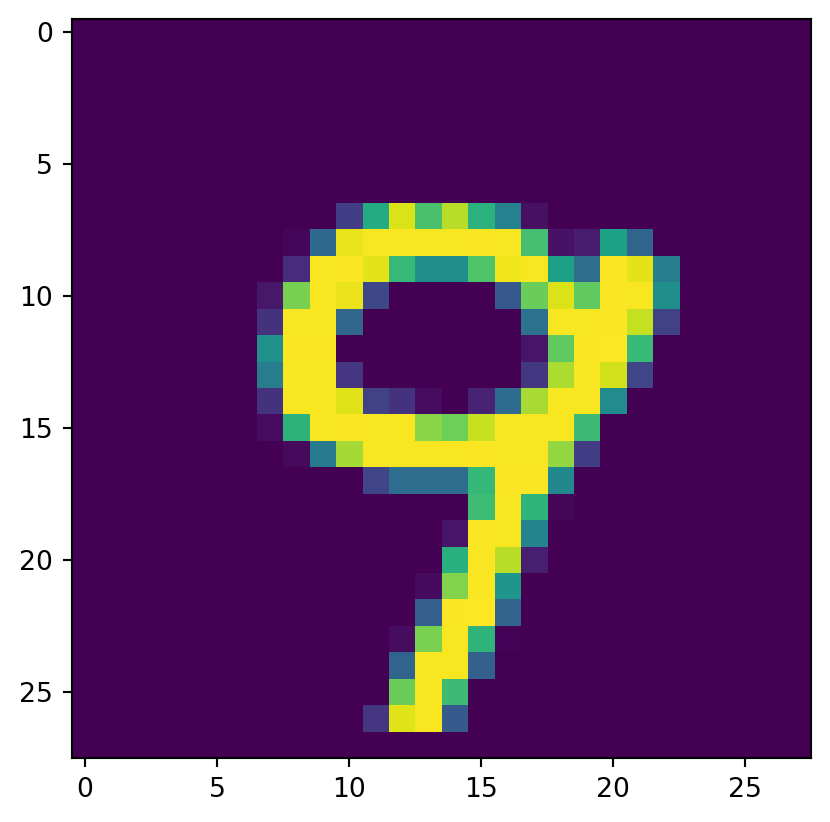

i = [20938]: This is supposed to be a 8:


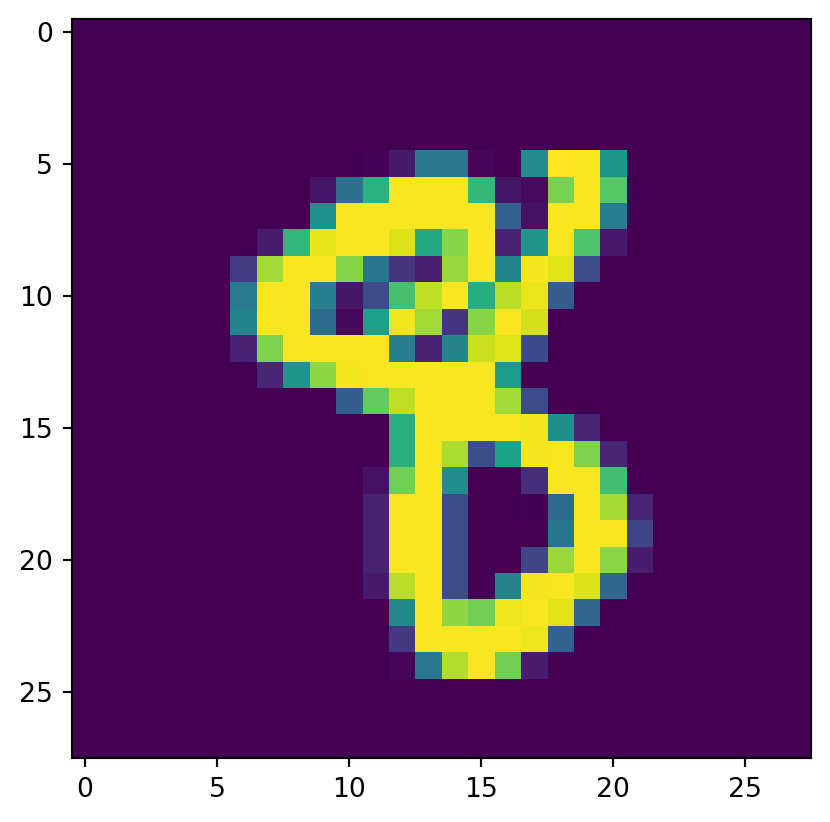

i = [63509]: This is supposed to be a 8:


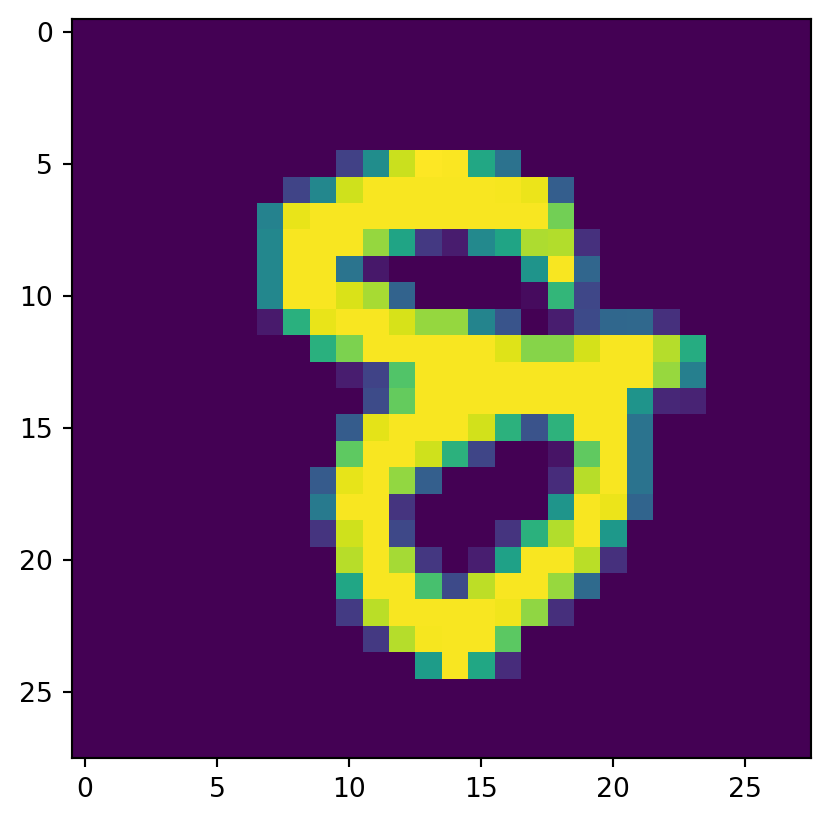

i = [42765]: This is supposed to be a 1:


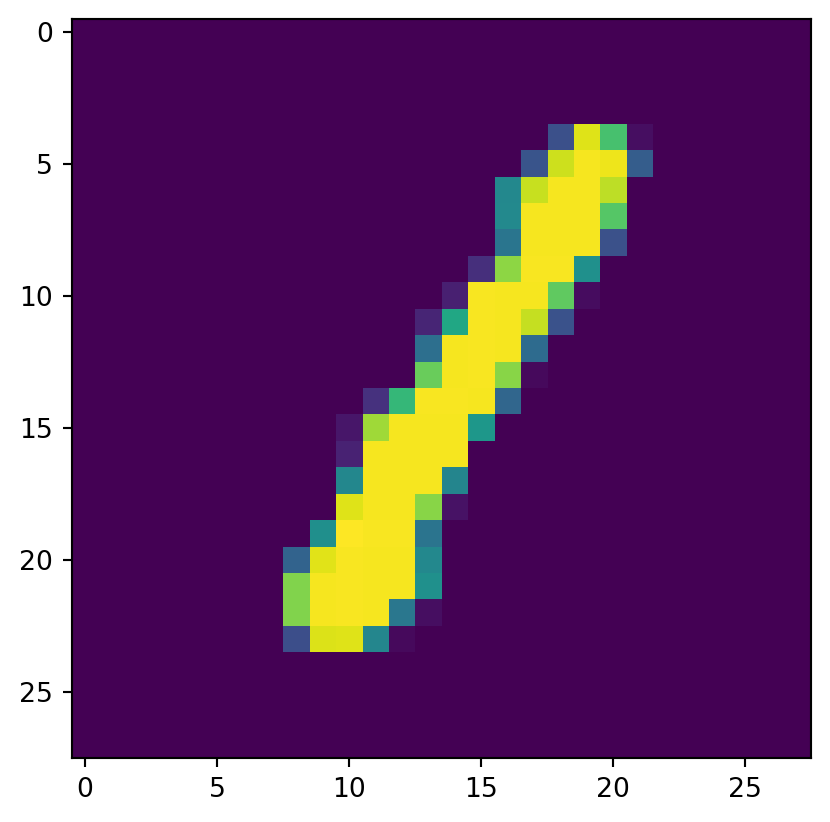

i = [429]: This is supposed to be a 0:


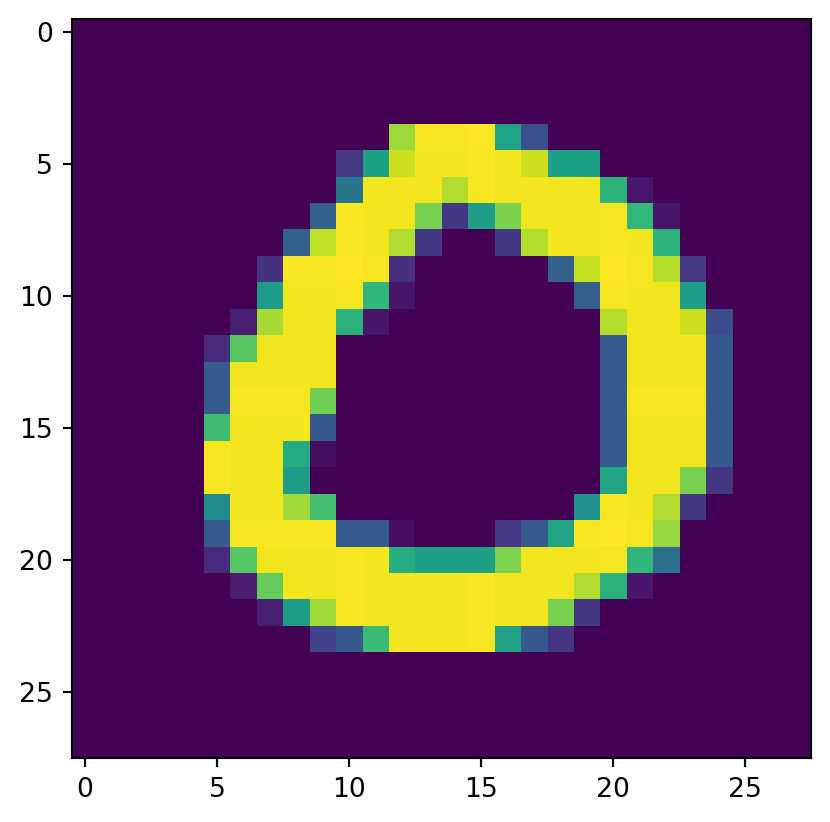

In [ ]:
#from sklearn.datasets import fetch_mldata
from sklearn.datasets import fetch_openml
from random import sample 

#mnist = fetch_mldata('MNIST original')
mnist = fetch_openml('mnist_784', version=1, cache=True)

X2 = mnist.data.to_numpy() / 255  # at some point they made MNSIT a pandas df
Y2 = np.array(mnist.target,dtype=np.int32) 

#Let's grab some indices for random suffling 
indices = list(range(X2.shape[0]))

# Let's look a a few examples
for i in range(8):  # 8 is good
    i = sample(indices,1)
    print(f"i = {i}: This is supposed to be a ",Y2[i][0],":",sep="")
    plt.imshow(X2[i].reshape([28,28]))
    plt.show()

In [ ]:
# Like we did before... Almost the whole PCA method is the next 3 lines! 
mnist_cov = np.cov(X2.T)
lambdas, vs = sorted_eig(np.array(mnist_cov))
W = vs[:,0:3]       # Grab the 3 most significant dimensions

# Plotting all 70,000 data points is going to be too dense too look at. 
# Instead let's grab a random sample of 5,000 points
n_plot = 5000
indices = sample(list(range(X2.shape[0])), n_plot)
proj_mnist = np.array(X2[indices] @ W, dtype=np.float32)  # Last step of PCA: project 

fig = go.Figure(data=[go.Scatter3d(x=proj_mnist[:,0], y=proj_mnist[:,1], z=proj_mnist[:,2],
                mode='markers', marker=dict(size=4, opacity=0.7, color=Y2[indices], 
                showscale=True), text=['digit='+str(j) for j in Y2[indices]] )])
fig.show()

...bit of a mess.  Not as cleanly separated as the 8x8 image examples.  You can see that the 0's are well separated from the 1's and the 3's, but everything else is pretty mixed together.  (I suspect the 1's are clustered strongly because they involve the most dark pixels.)

If you wanted to push this further then either keeping more dimensions (thereby making it un-visualizable) or just using a different method entirely (e.g. t-SNE or even better: [UMAP](https://pair-code.github.io/understanding-umap/)) would be the way to go.  Still, it's neat to see that you can get somewhat intelligible results in 3D even on this 'much harder' problem. 

# Appendix B: Because We Can: Turning it into a Classifier

...But let's not do a neural network because all I ever do are neural networks, and because I don't want to have take the time & space to explain how they work or load in external libraries.  Let's do k-nearest-neighbors instead, because it's intuitively easy to grasp and it's not hard to code up:

> For any new point we want to evaluate, we take a 'vote' of whatever some number (called $k$) of its nearest neighbor points are already assigned as, and we set the class of the new point according to that vote. 

<small>Making a efficient classifier is all about finding the *boundaries* between regions (and usually subject to some user-adjustable parameter like $k$ or some numerical threshold).  Finding these boundaries can be about finding the 'edge cases' that cause the system to 'flip' (discontinuously) from one result to another.   However, we are *not* going to make an efficient classifier today. ;-) </small>

Let's go back to the 8x8 digits example, and split it into a training set and a testing set (so we can check ourselves):

In [ ]:
# random shuffled ordering of the whole thing
indices = sample(list(range(X.shape[0])), X.shape[0])
X_shuf, Y_shuf = X[indices,:], Y[indices]

# 80-20 train-test split
max_train_ind = int(0.8*X.shape[0])    
X_train, Y_train = X_shuf[0:max_train_ind,:], Y_shuf[0:max_train_ind]
X_test, Y_test = X_shuf[max_train_ind:-1,:], Y_shuf[max_train_ind:-1] 

# Do PCA on training set 
train_cov = np.cov(X_train.T)
ell, v = sorted_eig(np.array(train_cov))
pca_dims = 3                # number of top 'dimensions' to take
W_train = v[:,0:pca_dims]   
proj_train = X_train @ W_train

# also project the testing set while we're at it
proj_test = X_test @ W_train   # yes, same W_train 

Now let's make a little k-nearest neighbors routine...


In [ ]:
from collections import Counter

def knn_predict(xnew, proj_train, Y_train, k=3):
    """
    xnew is a new data point that has the same shape as one row of proj_train.
    Given xnew, calculate the (squared) distance to all the points in X_train
    to find out which ones are nearest.
    """
    distances = ((proj_train - xnew)**2).sum(axis=1)  
    # stick on an extra column of indexing 'hash' for later use after we sort
    dists_i = np.stack( (distances, np.array(range(Y_train.shape[0]) )),axis=1 )
    dists_i = dists_i[dists_i[:,0].argsort()]    # sort in ascending order of distance
    knn_inds = (dists_i[0:k,-1]).astype(np.int32)  # Grab the indexes for k nearest neighbors
 
    # take 'votes':
    knn_targets = list(Y_train[knn_inds])  # which classes the nn's belong to
    votes = Counter(knn_targets)         #  count up how many of each class are represented
    return votes.most_common(1)[0][0]    # pick the winner, or the first member of a tie


# Let's test it on the first element of the testing set
x, y_true = proj_test[0], Y_test[0]
guess = knn_predict(x, proj_train, Y_train)
print("guess = ",guess,", true = ",y_true)

guess =  8 , true =  8


Now let's try it for the 'unseen' data in the testing set, and see how we do...

In [ ]:
mistakes, n_test = 0, Y_test.shape[0]
for i in range(n_test):
    x = proj_test[i]
    y_pred = knn_predict(x, proj_train, Y_train, k=3)
    y_true = Y_test[i]
    if y_true != y_pred:
        mistakes += 1 
    if i < 20:   # show some examples
        print("x, y_pred, y_true =",x, y_pred, y_true, 
              "YAY!" if y_pred==y_true else "     BOO. :-(")
print("...skipping a lot...")

print("Total Accuracy =", (n_test-mistakes)/n_test*100,"%")

x, y_pred, y_true = [-0.01242698  0.00547996  0.02020715] 8 8 YAY!
x, y_pred, y_true = [-0.04788666  0.03369412  0.00761786] 5 9      BOO. :-(
x, y_pred, y_true = [ 0.0394503  -0.11012404  0.04138117] 1 1 YAY!
x, y_pred, y_true = [-0.01624803  0.0017128   0.00093119] 8 2      BOO. :-(
x, y_pred, y_true = [-0.02510674 -0.02747576 -0.02851513] 8 9      BOO. :-(
x, y_pred, y_true = [ 0.04391237 -0.10986729  0.01005749] 1 1 YAY!
x, y_pred, y_true = [ 0.02785789 -0.02758998  0.03546457] 7 6      BOO. :-(
x, y_pred, y_true = [ 0.028658   -0.07597674  0.01924342] 7 1      BOO. :-(
x, y_pred, y_true = [-0.02178398  0.03732549  0.01712057] 5 5 YAY!
x, y_pred, y_true = [ 0.06365388 -0.05558701  0.07012057] 1 1 YAY!
x, y_pred, y_true = [-0.03698522 -0.00566659  0.01859906] 8 3      BOO. :-(
x, y_pred, y_true = [ 0.07903279 -0.02894052 -0.03747521] 4 4 YAY!
x, y_pred, y_true = [ 0.00711305  0.08348257 -0.03428523] 0 0 YAY!
x, y_pred, y_true = [ 0.00023215 -0.07071015 -0.0528109 ] 7 1      BOO. :-(

...eh! Not bad, not amazing.  You can improve the accuracy if you go back up and increase the number of PCA dimensions beyond 3, and/or increase the value of $k$.  Go ahead and try it! 

<small>(For 10 dimensions and 
$k=7$, I got 97.7% accuracy.   The highest I ever got it was 99%, but that was really working overtime, computationally speaking; the point of PCA is to let you dramatically reduce your workload while retaining reasonably high accuracy.)</small> 

Just to reiterate: This is NOT supposed to be a state of the art classifier!  It's just a toy that does pretty well and helps illustrate PCA without being hard to understand or code.  

# The End
Thanks for sticking around!  Hope this was interesting.  PCA is pretty simple, and yet really useful!  
...and writing this really helped *me* to better understand it. ;-) 